# Train a Semantic Segmentation Model using Segmentation-Models-PyTorch

[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/opengeos/geoai/blob/main/docs/examples/train_segmentation_model.ipynb)

This notebook demonstrates how to train semantic segmentation models for object detection (e.g., building detection) using the [segmentation-models-pytorch](https://smp.readthedocs.io) library. Unlike instance segmentation with Mask R-CNN, this approach treats the task as pixel-level binary classification.

## Install packages
To use the new functionality, ensure the required packages are installed.


In [1]:
%pip install geoai-py

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import libraries

In [2]:
import geoai

## Download sample data

We'll use the same dataset as the Mask R-CNN example for consistency.

In [3]:
train_raster_path = r"data\POC5\Roi_Jun16.tif"
train_vector_path = r"data\POC5\Labels.geojson"

## Visualize sample data

In [ ]:
geoai.get_raster_info(train_raster_path)

In [ ]:
geoai.view_vector_interactive(train_vector_path, tiles=train_raster_url)

In [ ]:
geoai.view_raster(test_raster_url)

## Create training data

We'll create the same training tiles as before.

In [3]:
out_folder = "results\POC5\semantic"
# tiles = geoai.export_geotiff_tiles(
#     in_raster=train_raster_path,
#     out_folder=out_folder,
#     in_class_data=train_vector_path,
#     tile_size=800,
#     stride=400,
#     buffer_radius=0,
# )

## Train semantic segmentation model

Now we'll train a semantic segmentation model using the new `train_segmentation_model` function. This function supports various architectures from `segmentation-models-pytorch`:

- **Architectures**: `unet`, `unetplusplus` `deeplabv3`, `deeplabv3plus`, `fpn`, `pspnet`, `linknet`, `manet`
- **Encoders**: `resnet34`, `resnet50`, `efficientnet-b0`, `mobilenet_v2`, etc.

For more details, please refer to the [segmentation-models-pytorch documentation](https://smp.readthedocs.io/en/latest/models.html).

### Example 1: U-Net with ResNet34 encoder


In [ ]:
# Train U-Net model
geoai.train_segmentation_model(
    images_dir=f"{out_folder}/images",
    labels_dir=f"{out_folder}/labels",
    output_dir=f"{out_folder}/unet_models",
    architecture="unet",
    encoder_name="resnet34",
    encoder_weights="imagenet",
    num_channels=3,
    num_classes=2,  # background and building
    batch_size=8,
    num_epochs=100,
    learning_rate=0.001,
    val_split=0.2,
    verbose=True,
)

### Example 2: SegFormer with resnet152 encoder

In [ ]:
geoai.train_segmentation_model(
    images_dir=f"{out_folder}/images",
    labels_dir=f"{out_folder}/labels",
    output_dir=f"{out_folder}/segformer_models",
    architecture="segformer",
    encoder_name="resnet152",
    encoder_weights="imagenet",
    num_channels=3,
    num_classes=2,
    batch_size=6,  # Smaller batch size for more complex model
    num_epochs=50,
    learning_rate=0.0005,
    val_split=0.2,
)

## Run inference

Now we'll use the trained model to make predictions on the test image.

In [16]:
# Define paths
out_folder = r"results\POC5\semantic"
test_raster_path = r"data\POC3\Test3_Jun16.tif"
masks_path = r"results\POC5\100Epochs_unet\Test3_Jun16_100unet_prediction.tif"
model_path = f"{out_folder}/unet_models/best_model.pth"

In [17]:
# Run semantic segmentation inference
geoai.semantic_segmentation(
    input_path=test_raster_path,
    output_path=masks_path,
    model_path=model_path,
    architecture="unet",
    encoder_name="resnet34",
    num_channels=3,
    num_classes=2,
    window_size=800,
    overlap=400,
    batch_size=4,
)

Processing 100 windows...


121it [01:32,  1.30it/s]                         


Predicted classes: 2 classes, Background: 76.7%
Inference completed in 94.29 seconds
Saved prediction to results\POC5\100Epochs_unet\Test3_Jun16_100unet_prediction.tif


## Vectorize masks

Convert the predicted mask to vector format for better visualization and analysis.

In [18]:
output_vector_path = r"results\POC5\100Epochs_unet\Test3_Jun16_100unet_prediction.geojson"
gdf = geoai.orthogonalize(masks_path, output_vector_path, epsilon=2)

Processing 940 features...


Converting features: 100%|██████████| 940/940 [00:09<00:00, 96.16shape/s] 


Saving to results\POC5\100Epochs_unet\Test3_Jun16_100unet_prediction.geojson...
Done!


## Add geometric properties

In [ ]:
gdf_props = geoai.add_geometric_properties(gdf, area_unit="m2", length_unit="m")

## Visualize results

In [ ]:
geoai.view_raster(masks_path, nodata=0, basemap=test_raster_url, backend="ipyleaflet")

In [ ]:
geoai.view_vector_interactive(gdf_props, column="area_m2", tiles=test_raster_url)

In [ ]:
gdf_filtered = gdf_props[(gdf_props["area_m2"] > 50)]

In [ ]:
geoai.view_vector_interactive(gdf_filtered, column="area_m2", tiles=test_raster_url)

In [ ]:
geoai.create_split_map(
    left_layer=gdf_filtered,
    right_layer=test_raster_url,
    left_args={"style": {"color": "red", "fillOpacity": 0.2}},
    basemap=test_raster_url,
)

## Model Performance Analysis

Let's examine the training curves and model performance:

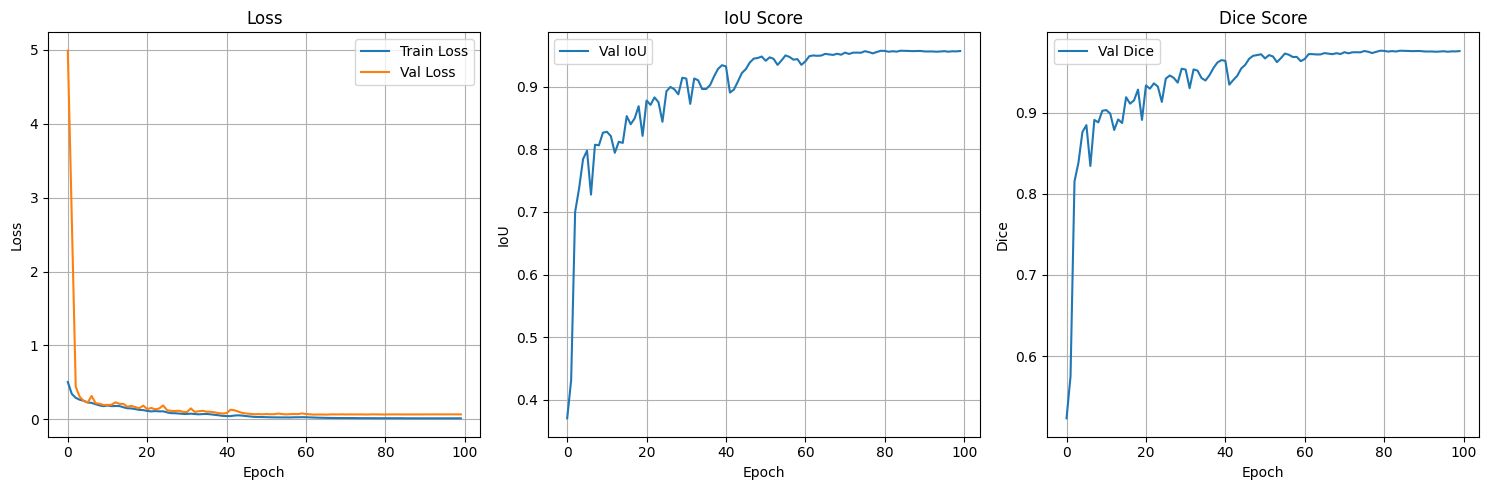

Best IoU: 0.9574
Best Dice: 0.9766
Final IoU: 0.9569
Final Dice: 0.9761


In [9]:
geoai.plot_performance_metrics(
    history_path=f"{out_folder}/unet_models/training_history.pth",
    figsize=(15, 5),
    verbose=True,
)

![image](https://github.com/user-attachments/assets/9355446f-f9ba-4818-aedb-4bb5dee56813)

## Performance Metrics

**IoU (Intersection over Union)** and **Dice score** are both popular metrics used to evaluate the similarity between two binary masks—often in image segmentation tasks. While they are related, they are not the same.

---

### 🔸 **Definitions**

#### **IoU (Jaccard Index)**

$$
\text{IoU} = \frac{|A \cap B|}{|A \cup B|}
$$

* Measures the overlap between predicted region $A$ and ground truth region $B$ relative to their union.
* Ranges from 0 (no overlap) to 1 (perfect overlap).

#### **Dice Score (F1 Score for Sets)**

$$
\text{Dice} = \frac{2|A \cap B|}{|A| + |B|}
$$

* Measures the overlap between $A$ and $B$, but gives more weight to the intersection.
* Also ranges from 0 to 1.

---

### 🔸 **Key Differences**

| Metric   | Formula                     | Penalizes                      | Sensitivity                      |
| -------- | --------------------------- | ------------------------------ | -------------------------------- |
| **IoU**  | $\frac{TP}{TP + FP + FN}$   | FP and FN equally              | Less sensitive to small objects  |
| **Dice** | $\frac{2TP}{2TP + FP + FN}$ | Less harsh on small mismatches | More sensitive to small overlaps |

> TP: True Positive, FP: False Positive, FN: False Negative

---

### 🔸 **Relationship**

Dice and IoU are mathematically related:

$$
\text{Dice} = \frac{2 \cdot \text{IoU}}{1 + \text{IoU}} \quad \text{or} \quad \text{IoU} = \frac{\text{Dice}}{2 - \text{Dice}}
$$

---

### 🔸 **When to Use What**

* **IoU**: Common in object detection and semantic segmentation benchmarks (e.g., COCO, Pascal VOC).
* **Dice**: Preferred in medical imaging and when class imbalance is an issue, due to its sensitivity to small regions.